# Mechanics and energetics of aging skeletal muscle 

This code is designed to model the mechanics and energetics of aging skeletal muscle by using a Hill-type model and energetics model. 


In [1]:
# Import statements 
import numpy as np
import matplotlib.pyplot as plt
font = {'size'   : 12}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [9.0/2.56, 8.0/2.56]
plt.rcParams['figure.dpi'] = 150

# Define color palette and marker styles
palette = ["#0063c0", "#ff6600", "#8d0808"]
markerlist = ('solid','dashed','dotted','dashdot',(0, (3, 5, 1, 5, 1, 5)))

### Look at the effect of change in muscle properties with age on muscle force 

Here we look at the effects of muscle aging on the force-velocity relationship of muscle.

The changes with age on fibre-type properties are derived from Zampeiri et al. 2015 on aging in human muscle in typical older adults and active older adults.

Muscle maximum forces are obtained for young adult vastus lateralis from Handfield et al. 2014, and scaled for older adults based on MVC torques from Zampeiri et al. 2015.

Note the effects of age modelled here represent a subset of the complete changes that occur to muscle.

Zampieri, S., Pietrangelo, L., Loefler, S., Fruhmann, H., Vogelauer, M., Burggraf, S., Pond, A., Grim-Stieger, M., Cvecka, J., Sedliak, M. et al. (2015). Lifelong physical exercise delays age-associated skeletal muscle decline. The Journals of Gerontology. Series A, Biological Sciences and Medical Sciences 70, 163-173.


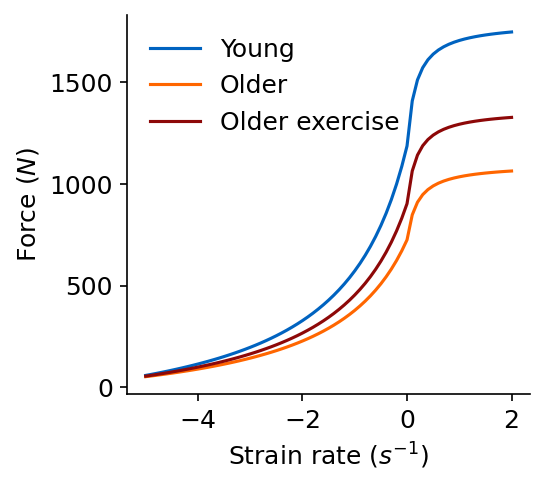

In [2]:
# Force-velocity relationship as defined in Dick et al. 2017
def F_va(dedt_ce, v_max, a):
        return (1+dedt_ce/v_max)/(1-dedt_ce/v_max/a) * (dedt_ce < 0) \
                + (1.5 - 0.5*(1-dedt_ce/v_max)/(1+7.56 * dedt_ce/v_max / a))*(dedt_ce >0)\
                + (dedt_ce == 0)

# Range of shortening rates 
v_short_list = np.linspace(-5, 2, 71) # Units of l_0 s^{-1}

# Define level of activation 
act_level = 1 # Set at 100% activation

# Define plot labels 
labels_plot = ('Young', 'Older', 'Older exercise')

# Set the slow fibre-type proportions that scale the v_max and a parameters 
# Order: young, old, old exercise
# alpha_s_list = np.array((0.35, 0.408, 0.565)) # data from McKendry et al. 2020 
alpha_s_list = np.array((0.688, 0.548, 0.618)) # data from Zampeiri et al. 2015

# Knee torque based on experimental data
# Order: young, old, old exercise
# mvc_torque_list = np.array((50.9, 46.3, 47.0)) # data from McKendry et al. 2020 
mvc_torque_list = np.array((3.2 * 73.8, 1.7 * 84.9, 2.2 * 81.7)) # data from Zampeiri et al. 2015

# Define v_max based for slow and fast fibre-types
v_max_s = 5 # s^{-1}
v_max_f = 10 # s^{-1} 

# Define force-velocity parameter for slow and fast fibre-types
a_s = 0.18 # unitless
a_f = 0.25 # unitless


# Compute forces for each of the different fibre-type proportions 
force_list = np.empty_like(alpha_s_list, dtype = object)
fig, ax = plt.subplots(layout = 'constrained')
ax.set_xlabel('Strain rate ($s^{-1}$)')
ax.set_ylabel('Force ($N$)')
# ax.set_title('Aging effect of fibre-type proportion')
for i, alpha_s in enumerate(alpha_s_list): 

        # Scale the force based on differences in MVC torque 
        scale_factor =  mvc_torque_list[i] / mvc_torque_list[0]
        F_0 = scale_factor * (59.3) * 1e-4 * 2e5 # PCSA from Handsfield et al. 2014
        # F_0 = mvc_torque_list[i] / 0.02 # N, moment arm from Buford et al. 1997 

        # Compute v_max
        v_max = alpha_s * v_max_s + (1 - alpha_s) * v_max_f # s^{-1}

        # Compute force-velo parameter
        a = alpha_s * a_s + (1 - alpha_s) * a_f # unitless

        # Compute the forces
        force_list[i] = F_0 * act_level * F_va(v_short_list, v_max, a)
        
        # Plot the results
        ax.plot(v_short_list, force_list[i], label=labels_plot[i], color = palette[i])
ax.legend(frameon=False)
ax.spines[['right', 'top']].set_visible(False)
# fig.savefig('./ForceVelocityRel.jpg')
# fig.savefig('./ForceVelocityRel.svg')

plt.show()

### The effects of age on the energetics of muscle contraction at varying shortening rates

Here we use the same parameters as in the force calculations with respect to changes in fibre-types. 

To ensure comparable contractions for energetic rates, we match force during an isometric contraction by scaling the activation levels. 

Energetics parameters are derived in Konno et al. 2025 based on data from Barclay 1996.

Barclay, C. J. (2019). Efficiency of Skeletal Muscle. In Muscle and Exercise Physiology, pp. 111-127: Academic Press.

Konno, R. N., Lichtwark, G. A. and Dick, T. J. M. (2025). Using physiologically-based models to predict in vivo skeletal muscle energetics. Journal of Experimental Biology, jeb.249966.


_______________________________
Condition: Young
Activation = 0.5
% increase from young = 0.0%
F_0 = 1186.0 N
_______________________________
Condition: Older
Activation = 0.8181251299106216
% increase from young = 63.62502598212431%
F_0 = 724.8279979674796 N
_______________________________
Condition: Older exercise
Activation = 0.6569489262267719
% increase from young = 31.389785245354386%
F_0 = 902.6576897018971 N


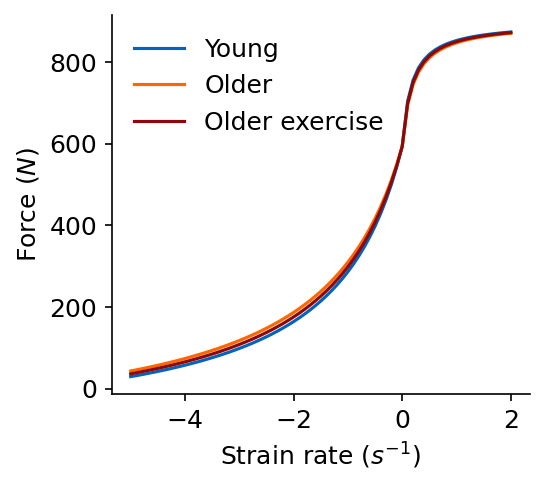

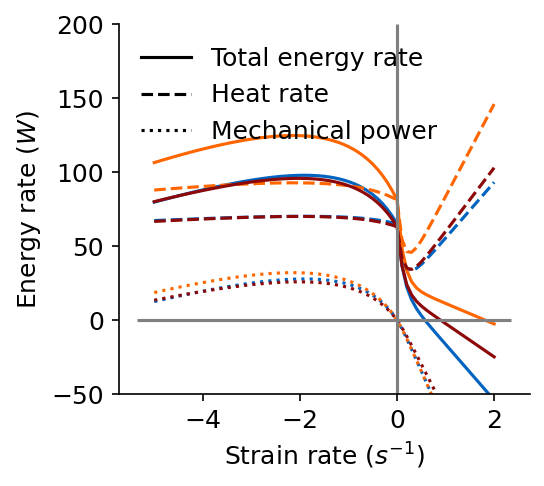

In [3]:
# Define the energetics parameters 

# Maintenance
r1_min = 0.6177 
r1_max = 2.7919 

# Shortening
r2_min = 0.2342
r2_max = 0.697 

# Define the fascicle lengths, Data from McKendry et al. 2020 (Supplementary)
l_0_list = np.array((84.4, 85.5, 73.4)) * 1e-3

# Define the energetics functions 
def computeEnergy(act, v_short, force, F_0_, l_0_, r1_, r2_): 
    # Returns heat, work, and total energetic cost

    # Maintenance heat rate 
    heat_m = (r1_ * act * F_0_ * l_0_) * (v_short < 0) \
        + (r1_ * act * F_0_ * l_0_) * (0.3 + 0.7 * np.exp(-8 * v_short)) * (v_short >= 0) # W

    # Shortening heat rate 
    heat_s = r2_ * act * -v_short * force / F_0_ * F_0_ * l_0_ * (v_short < 0) \
        + act * force * v_short * l_0_ * (v_short >= 0) # W

    # Total heat rate 
    heat = heat_m + heat_s
    
    # Work 
    work = force * -v_short * l_0_ # W

    # Total energetic rate
    total = (heat + work )# W 

    return heat, work, total

# Get the idx of the v_short = 0 
idx_iso = np.where(v_short_list == 0)[0][0]

# Activation level to produce the same force as the young adult
act_level = 0.5
act_level_list = (act_level, force_list[0][idx_iso] / force_list[1][idx_iso] * act_level, force_list[0][idx_iso] / force_list[2][idx_iso] * act_level) 

# Initialise
force_list_energy = np.empty_like(alpha_s_list, dtype = object)
heat_list = np.empty_like(alpha_s_list, dtype = object)
work_list = np.empty_like(alpha_s_list, dtype = object)
ener_list = np.empty_like(alpha_s_list, dtype = object)

# Initialise plots
fig_force, ax_force = plt.subplots(layout = 'constrained')
ax_force.set_xlabel('Strain rate ($s^{-1}$)')
ax_force.set_ylabel('Force ($N$)')
fig_energ, ax_energ = plt.subplots(layout = 'constrained')
ax_energ.set_xlabel('Strain rate ($s^{-1}$)')
ax_energ.set_ylabel('Energy rate ($W$)')

# Loop over the conditions 
# .... compute the energy required for the older adults to produce the same force as the young adult 
for i, act_level_ in enumerate(act_level_list):
    print('_______________________________')
    print(f'Condition: {labels_plot[i]}')
    print(f'Activation = {act_level_}')
    print(f'% increase from young = {(act_level_ / act_level_list[0] - 1) * 100}%')


    # Get the fascicle length for the current condition
    l_0 = l_0_list[i]

    # Define the fraction of slow fibres 
    alpha_s = alpha_s_list[i]

    # Scale the force based on differences in MVC torque 
    scale_factor =  mvc_torque_list[i] / mvc_torque_list[0]
    F_0 = scale_factor * (59.3) * 1e-4 * 2e5 # PCSA from Handsfield et al. 2014
    # F_0 = mvc_torque_list[i] / 0.02 # N, moment arm from Buford et al. 1997 
    print(f'F_0 = {F_0} N')

    # Compute v_max
    v_max = alpha_s * v_max_s + (1 - alpha_s) * v_max_f # s^{-1}

    # Compute force-velo parameter
    a = alpha_s * a_s + (1 - alpha_s) * a_f # unitless

    # Compute the forces
    force_list_energy[i] = F_0 * act_level_ * F_va(v_short_list, v_max, a)

    # Compute the energetic rate constants 
    r1 = alpha_s * r1_min + (1 - alpha_s) * r1_max 
    r2 = alpha_s * r2_min + (1 - alpha_s) * r2_max 
    
    # Compute the energy for the current condition
    heat_list[i], work_list[i], ener_list[i] = computeEnergy(act_level_, v_short_list, force_list_energy[i], F_0, l_0, r1, r2)

    # Plot the forces
    ax_force.plot(v_short_list, force_list_energy[i], label=labels_plot[i], color = palette[i])
    if i == 0: 
        ax_energ.plot(v_short_list, ener_list[i],                 label = 'Total energy rate', color = palette[i])
        ax_energ.plot(v_short_list, heat_list[i], linestyle='--', label = 'Heat rate',         color = palette[i])
        ax_energ.plot(v_short_list, work_list[i], linestyle=':' , label = 'Mechanical power',  color = palette[i])
    else: 
        ax_energ.plot(v_short_list, ener_list[i],                 label = None, color = palette[i])
        ax_energ.plot(v_short_list, heat_list[i], linestyle='--', label = None, color = palette[i])
        ax_energ.plot(v_short_list, work_list[i], linestyle=':' , label = None, color = palette[i])


ax_force.legend(frameon=False)
ax_force.spines[['right', 'top']].set_visible(False)
# fig_force.savefig('./ForceMatched.jpg')
# fig_force.savefig('./ForceMatched.svg')

legend = ax_energ.legend(frameon=False)
for handle in legend.legend_handles:
    handle.set_color('black')
ax_energ.set_ylim((-50, 200))
ymin_, ymax_ = ax_energ.get_ylim()
ax_energ.vlines(0, ymin_, ymax_, color = 'gray')
xmin_, xmax_ = ax_energ.get_xlim()
ax_energ.hlines(0, xmin_, xmax_, color = 'gray')
ax_energ.spines[['right', 'top']].set_visible(False)
# fig_energ.savefig('./Energetics.jpg')
# fig_energ.savefig('./Energetics.svg')

plt.show()